In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

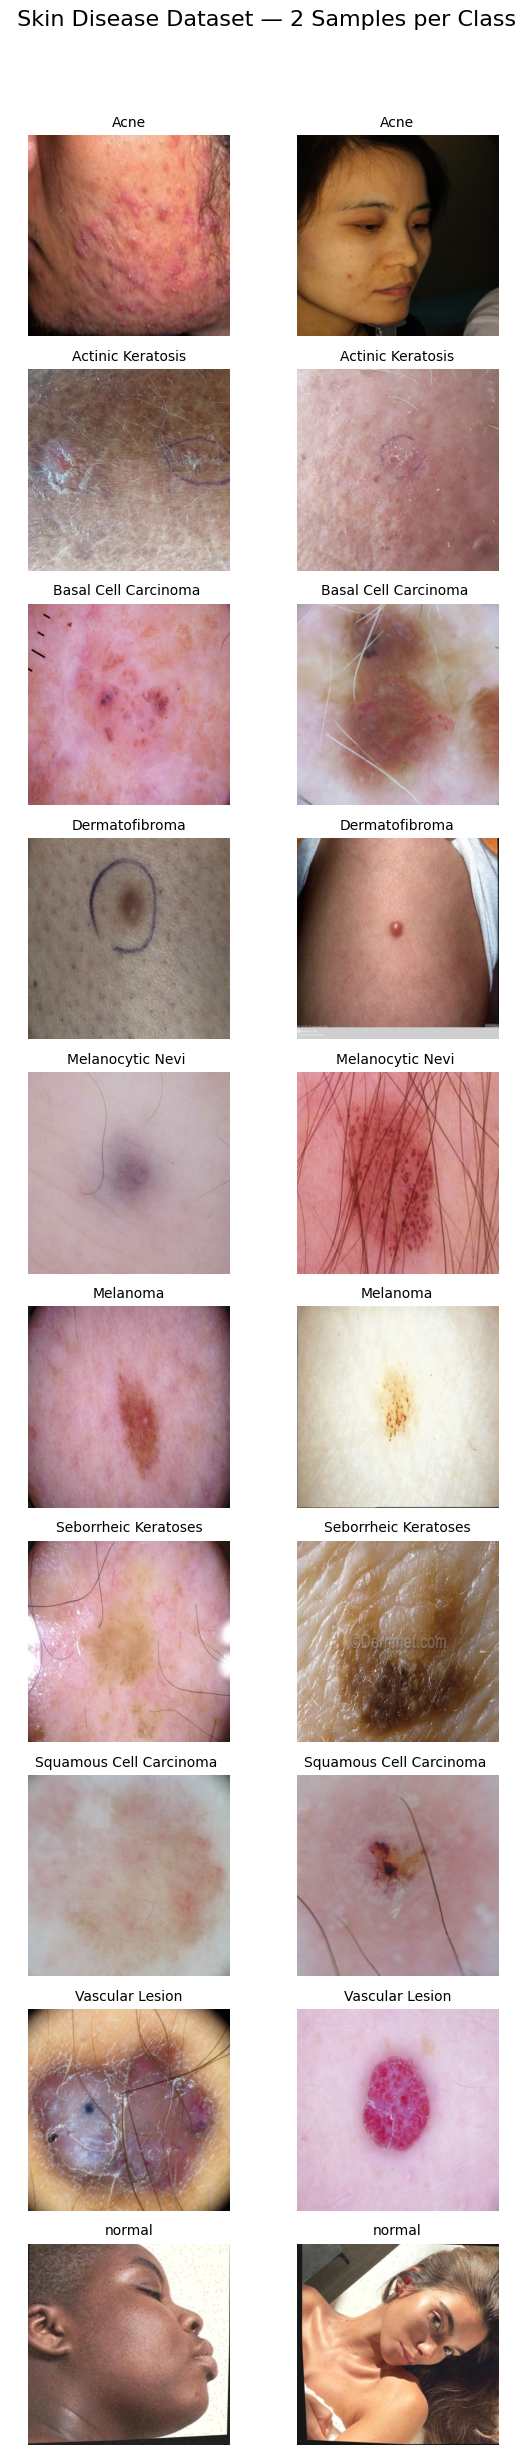

In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your dataset
base_dir = "/home/jay/Face_Analysis/datasets/skin_diseases"

# Automatically get sorted class names/folder names
class_labels = sorted(os.listdir(base_dir))
images_per_class = 2
num_classes = len(class_labels)

# grid plot
plt.figure(figsize=(images_per_class * 3, num_classes * 2.5))

for class_idx, class_name in enumerate(class_labels):
    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)[:images_per_class] 

    for img_idx, img_file in enumerate(image_files):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path)

        plot_index = class_idx * images_per_class + img_idx + 1
        plt.subplot(num_classes, images_per_class, plot_index)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name, fontsize=10)

plt.suptitle(" Skin Disease Dataset — 2 Samples per Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [8]:
from collections import Counter
class_counts = {cls: len(os.listdir(os.path.join(base_dir, cls))) for cls in class_labels}
print(class_counts)


{'Acne': 2538, 'Actinic Keratosis': 852, 'Basal Cell Carcinoma ': 2457, 'Dermatofibroma': 203, 'Melanocytic Nevi ': 8679, 'Melanoma': 4797, 'Seborrheic Keratoses': 2491, 'Squamous Cell Carcinoma ': 628, 'Vascular Lesion': 253, 'normal': 1104}


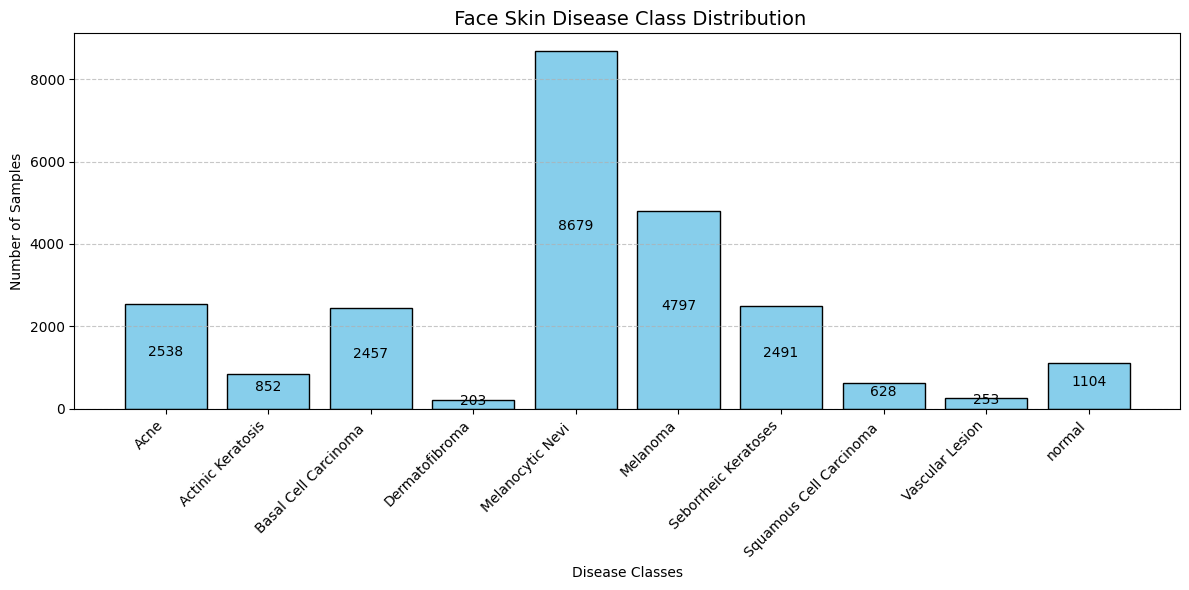

In [9]:
import matplotlib.pyplot as plt

# Function to place labels at the center of each bar
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] // 2, str(y[i]), ha='center', fontsize=10, color='black')

# Prepare data
disease_names = list(class_counts.keys())
disease_counts = list(class_counts.values())

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(disease_names, disease_counts, color='skyblue', edgecolor='black')

add_labels(disease_names, disease_counts)
plt.xticks(rotation=45, ha='right')
plt.title(' Face Skin Disease Class Distribution', fontsize=14)
plt.xlabel('Disease Classes')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [10]:
import os
import shutil
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  CONFIG 
SOURCE_DIR = "/home/jay/Face_Analysis/datasets/skin_diseases"
TARGET_DIR = "/home/jay/Face_Analysis/datasets/skin_diseases_balanced"
TARGET_OVERSAMPLE = 2000
TARGET_UNDERSAMPLE = 3000
TEST_SPLIT = 0.2
IMAGE_SIZE = (224, 224)

# Create folders 
for split in ["train", "test"]:
    for cls in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

# Define augmentor 
augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Helper to detect blank images 
def is_blank_image(img_path, threshold=10):
    try:
        img = Image.open(img_path).convert("L").resize(IMAGE_SIZE)
        stddev = np.std(np.array(img))
        return stddev < threshold
    except:
        return True

# Augment one image
def augment_image(image_path):
    img = Image.open(image_path).convert("RGB").resize(IMAGE_SIZE)
    x = np.array(img) / 255.0
    x = x.reshape((1,) + x.shape)
    aug_iter = augmentor.flow(x, batch_size=1)
    aug_img = next(aug_iter)[0]
    return Image.fromarray((aug_img * 255).astype("uint8"))



In [11]:
# Process all classes
for class_name in tqdm(os.listdir(SOURCE_DIR), desc="Balancing dataset"):
    class_path = os.path.join(SOURCE_DIR, class_name)
    images = [f for f in os.listdir(class_path) if not is_blank_image(os.path.join(class_path, f))]
    random.shuffle(images)

    # UNDERSAMPLING
    if len(images) > TARGET_UNDERSAMPLE:
        images = images[:TARGET_UNDERSAMPLE]

    # Split into train/test
    test_count = int(TEST_SPLIT * len(images))
    train_images = images[test_count:]
    test_images = images[:test_count]

    # Copy test images
    for img_name in test_images:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(TARGET_DIR, "test", class_name, img_name)
        shutil.copy(src, dst)

    # Copy train images
    for img_name in train_images:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(TARGET_DIR, "train", class_name, img_name)
        shutil.copy(src, dst)

    # OVERSAMPLING
    current_train_count = len(train_images)
    if current_train_count < TARGET_OVERSAMPLE:
        needed = TARGET_OVERSAMPLE - current_train_count
        print(f" Oversampling '{class_name}' with {needed} images")

        for i in range(needed):
            base_img = random.choice(train_images)
            base_path = os.path.join(class_path, base_img)
            try:
                aug_img = augment_image(base_path)
                aug_name = f"aug_{i}_{base_img}"
                aug_img.save(os.path.join(TARGET_DIR, "train", class_name, aug_name))
            except Exception as e:
                print(f" Failed to augment {base_img}: {e}")

print(" Dataset balancing complete.")


Balancing dataset:   0%|                                 | 0/10 [00:00<?, ?it/s]

 Oversampling 'Squamous Cell Carcinoma ' with 1513 images


Balancing dataset:  10%|██▌                      | 1/10 [00:11<01:40, 11.17s/it]

 Oversampling 'normal' with 1116 images


Balancing dataset:  20%|█████                    | 2/10 [00:25<01:42, 12.82s/it]

 Oversampling 'Vascular Lesion' with 1800 images


Balancing dataset:  30%|███████▌                 | 3/10 [00:38<01:31, 13.12s/it]

 Oversampling 'Basal Cell Carcinoma ' with 74 images


Balancing dataset:  40%|██████████               | 4/10 [00:44<01:00, 10.16s/it]

 Oversampling 'Dermatofibroma' with 1839 images


Balancing dataset:  50%|████████████▌            | 5/10 [01:00<01:02, 12.51s/it]

 Oversampling 'Actinic Keratosis' with 1328 images


Balancing dataset:  60%|███████████████          | 6/10 [01:30<01:13, 18.42s/it]

 Oversampling 'Seborrheic Keratoses' with 37 images


Balancing dataset: 100%|████████████████████████| 10/10 [01:55<00:00, 11.51s/it]

 Dataset balancing complete.
